# Hoffman LFP classifier setup version!

In [24]:
import pandas as pd; pd.set_option('display.max_columns', 30)
import numpy as np
import sys
import os
import re
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['pdf.fonttype'] = 42; plt.rcParams['ps.fonttype'] = 42 # fix fonts for Illustrator
from copy import copy
from scipy import stats,signal
from ptsa.data.timeseries import TimeSeries
import time
import mat73 # this loads .mat files as dicts
import warnings
warnings.filterwarnings("ignore", message="Unable to parse")
warnings.filterwarnings("ignore", message="Invalid")

sys.path.append('/u/home/j/jsakon/johnModules')
%load_ext autoreload
%autoreload
from general import *

import neuralynx_io

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
# programs

def find_files_in_range(directory, extension, min_size, max_size, include_subdirs=False):
    """
    Find files in the specified directory with the given extension that are bigger than min_size megabytes 
    and smaller than max_size megabytes. Optionally includes or excludes subdirectories in the search.
    
    :param directory: The directory in which to start the search
    :param extension: The file extension to look for, e.g., '.txt'
    :param min_size: The minimum size of the files in megabytes
    :param max_size: The maximum size of the files in megabytes
    :param include_subdirs: Boolean indicating whether to include subdirectories in the search
    :return: A list of file paths that match the criteria
    """
    matching_files = []
    if include_subdirs:
        # Search in the specified directory and all subdirectories
        for foldername, subfolders, filenames in os.walk(directory):
            for filename in filenames:
                if filename.endswith(extension):
                    filepath = os.path.join(foldername, filename)
                    file_size_mb = os.path.getsize(filepath) / (1024 * 1024)  # convert size to MB
                    
                    if min_size <= file_size_mb <= max_size:
                        matching_files.append(filepath)
    else:
        # Search only in the specified directory
        for filename in os.listdir(directory):
            if filename.endswith(extension):
                filepath = os.path.join(directory, filename)
                file_size_mb = os.path.getsize(filepath) / (1024 * 1024)  # convert size to MB
                
                if min_size <= file_size_mb <= max_size:
                    matching_files.append(filepath)        
    return matching_files
def extract_info(filepath):
    basename = os.path.basename(filepath)
    match = re.search(r"([A-Za-z]+)(\d+)_?\d*\.ncs$", basename)
    if match:
        prefix, number = match.groups()
        return prefix, int(number), filepath
    else:
        raise ValueError(f"Unexpected filename format: {basename}")
def natural_sort_key(s):
    # This function breaks the input string into a list of substrings and numbers.
    # Numbers are converted to integers so that they're compared numerically. Non-numbers are compared as strings.
    return [int(text) if text.isdigit() else text.lower() for text in re.split('([0-9]+)', s)]  
def scatterWithFirstSecondStds(ax,data1,data2,improve_labels = False):
    ax.scatter(data1, data2)
    texts = [plt.text(data1[i], data2[i],txt,ha='left', va='bottom') for i, txt in enumerate(range(len(data1)))]
    if improve_labels == True:
        adjust_text(texts) # this is cool but it takes dozens of seconds
    ax.vlines(np.mean(data1)+np.std(data1),np.min(data2),np.max(data2),color=(0.6,0.6,1),linestyle='--') # 1 std
    ax.hlines(np.mean(data2)+np.std(data2),np.min(data1),np.max(data1),color=(0.6,0.6,1),linestyle='--') # 1 std
    ax.vlines(np.mean(data1)+2*np.std(data1),np.min(data2),np.max(data2),color=(1,0.6,0.6),linestyle='--') # 2 std
    ax.hlines(np.mean(data2)+2*np.std(data2),np.min(data1),np.max(data1),color=(1,0.6,0.6),linestyle='--') # 2 std
    return ax,texts
# Function to check if a number is within any of the specified ranges
def is_number_in_ranges(number, ranges):
    for start, end in ranges:
        if start <= number <= end:
            return True
    return False

# 3 cells you need to change things (cells 1-3 below)

## 1) load your folder to get the filenames

In [26]:
##  example data on Hoffman ##
dir_path = '/u/project/ifried/jsakon/564/564_Movie_pre- and post-sleep LFP/ZUGARO_EXP4_MTLONLY_SLEEP/first_few_hours_sleep_data'


file_extension = '.ncs'
min_size_mb = 0.5  # MB
max_size_mb = 250  # MB # should not be more than 29.4MB for macros...since that's size after 2 hours when NLX creates a new file
# actually Iowa's max seems to be 58.7 MB. Dunno why. And combined sleep files will of course be 3-4x bigger

files = find_files_in_range(dir_path, file_extension, min_size_mb, max_size_mb)

# Extract possible electrode names
matches = [re.search(r'([^/]+?)[_.]', os.path.basename(file)).group(1) for file in files] # if you want numbers with electrode names
# remove electrode numbers if they exist
for i_match,match in enumerate(matches):
    if match[-1].isdigit():
        matches[i_match] = match[:-1]
possible_electrode_names = list(np.sort(list(set(matches))))
last_electrode_mask = np.zeros(len(files)); # create set of 0s for cell below
print(possible_electrode_names)

['LAH', 'RA', 'RAH']


## 2) manually input the array of *electrode_prefixes* using the last printout to get all filenames
## 2.1) Note that for *Iowa* data need to manually adjust *exclude_elec_ranges* and *last_elec_array* to get bipolar data (also you must set *electrode_prefixes* to ['LFP'])

In [27]:
print_num = 20 # number of filtered_files to show

# *** For UCLA data just need to fill out electrode_prefixes to select LFP channels and/or get bipolar referencing ***
# electrode_prefixes = ['LA', 'LAC', 'LFSG', 'LMH', 'LOF', 'LOPR', 'LSTG', 'RA', 'RAI', 'RMH', 'ROF'] # p566
# electrode_prefixes = ['LAH', 'LSTG', 'LTPJ', 'RA', 'RAH', 'RO', 'ROA', 'RPHG', 'RPO', 'RTPJ'] # p564
# electrode_prefixes = ['LA', 'LAH', 'LIFG', 'RA', 'RAC', 'RAH', 'REC', 'RMFG', 'ROAI', 'ROF', 'ROPR'] # p565
electrode_prefixes = ['LAH', 'RA', 'RAH'] # Zugaro MTL elecs
# electrode_prefixes = ['RMH'] # selecting single channel

# *** For Iowa data: 1) put ['LFP'] for electrode_prefixes, 2) manually add your last_elec_array array below,
# and 3) manually add your exclude_elec_ranges to remove channels without LFP from filtered_files 
# electrode_prefixes = ['LFP'] # for Iowa data (since they don't name their elecs) 

# If not Iowa data can just leave these here (won't be used)
# i717
exclude_elec_ranges = [[1,6],[15,16],[42,48],[90,96],[123,128],[156,256]] # i717 excluded channels
last_elec_array = [14,24,32,41,56,64,72,80,89,105,113,122,137,146,155] # i717 last electrode in each shank

# enter info up to here ^^^
# **********

if electrode_prefixes == ['LFP']:
    Iowa_data = 1
else:
    Iowa_data = 0
# get files with prefixes above
filtered_files = [filename for filename in files if any(os.path.basename(filename).startswith(prefix) for prefix in electrode_prefixes)]
filtered_files = sorted(filtered_files, key=natural_sort_key)

if Iowa_data == 1:
    # Extracting the number before ".ncs" and filtering the files
    filtered_files = [file for file in filtered_files \
                        if not is_number_in_ranges(int(re.search(r'(\d+)\.ncs$', file).group(1)), exclude_elec_ranges)]
    last_electrode_mask = [1 if int(re.search(r'(\d+)\.ncs$', path).group(1)) \
                            in last_elec_array else 0 for path in filtered_files]  

# create a mask that identifies the last electrode in each group so can skip that one for bipolar
        
file_info = [extract_info(path) for path in filtered_files]

# Identify the max number for each prefix
max_numbers = {}
for prefix, number, _ in file_info:
    if prefix not in max_numbers:
        max_numbers[prefix] = number
    else:
        max_numbers[prefix] = max(max_numbers[prefix], number)

# Generate the mask based on these maximum channel numbers
if Iowa_data == 0:
    last_electrode_mask = [1 if number == max_numbers[prefix] else 0 for prefix, number, _ in file_info]
elif Iowa_data == 1:
    print('*** Using Iowa data so make sure you defined your mask above!! ***')
print('The first '+str(print_num)+' filenames loaded:')
filtered_files[0:print_num]  
print(last_electrode_mask)

print('Data length: '+str(len(neuralynx_io.load_ncs(filtered_files[0])['data'])))
print('(which is '+str(len(neuralynx_io.load_ncs(filtered_files[0])['data'])/2000/60)+' minutes of 2000 Hz sampled data')

The first 20 filenames loaded:


['/u/project/ifried/jsakon/564/564_Movie_pre- and post-sleep LFP/ZUGARO_EXP4_MTLONLY_SLEEP/first_few_hours_sleep_data/LAH1.ncs',
 '/u/project/ifried/jsakon/564/564_Movie_pre- and post-sleep LFP/ZUGARO_EXP4_MTLONLY_SLEEP/first_few_hours_sleep_data/LAH2.ncs',
 '/u/project/ifried/jsakon/564/564_Movie_pre- and post-sleep LFP/ZUGARO_EXP4_MTLONLY_SLEEP/first_few_hours_sleep_data/LAH3.ncs',
 '/u/project/ifried/jsakon/564/564_Movie_pre- and post-sleep LFP/ZUGARO_EXP4_MTLONLY_SLEEP/first_few_hours_sleep_data/LAH4.ncs',
 '/u/project/ifried/jsakon/564/564_Movie_pre- and post-sleep LFP/ZUGARO_EXP4_MTLONLY_SLEEP/first_few_hours_sleep_data/RA1.ncs',
 '/u/project/ifried/jsakon/564/564_Movie_pre- and post-sleep LFP/ZUGARO_EXP4_MTLONLY_SLEEP/first_few_hours_sleep_data/RA2.ncs',
 '/u/project/ifried/jsakon/564/564_Movie_pre- and post-sleep LFP/ZUGARO_EXP4_MTLONLY_SLEEP/first_few_hours_sleep_data/RA3.ncs',
 '/u/project/ifried/jsakon/564/564_Movie_pre- and post-sleep LFP/ZUGARO_EXP4_MTLONLY_SLEEP/first_few

[0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1]
Data length: 12857344
(which is 107.14453333333333 minutes of 2000 Hz sampled data


#### this should display your mask with 1 at the end of every shank...so usually 7-8 0s followed by a 1 over and over

## 3) Decide on bipolar, desired SR, and time range of data

In [28]:
# from ptsa.data.timeseries import TimeSeries

bipolar_ref = 1
desired_samplerate = 500 # Hz. 2000 Hz is default. Decimating takes ~15% longer to run
plot_whole_session = 1 # if 1, this will plot the whole session, and the code below will change precision from float64 to float16 to avoid memory errors. 
# If 0, change start_time and end_time here:
start_time = 0 # in ms
end_time = 3600000 # in ms % note: not used if plot_whole_session == 1

##### *** select time range *** #####
current_sr = neuralynx_io.load_ncs(filtered_files[0])['sampling_rate'] # NLX micros at 32K, macros at 2k  
sr_factor = current_sr/1000
if plot_whole_session == 0:
    time_range = range(int(start_time*sr_factor),int(end_time*sr_factor))    
elif plot_whole_session == 1:
    time_range = range(0,len(neuralynx_io.load_ncs(filtered_files[0])['data'])) # full data      

lfp_mat = []
channel_names = []
for i_file in range(len(filtered_files)):
    if bipolar_ref == 1:
        if last_electrode_mask[i_file] == 0:
            # save time loading the same file twice using logic
            if i_file == 0: # beginning of first shank
                begin_time = time.time()
                first_file = neuralynx_io.load_ncs(filtered_files[i_file])['data'][time_range]
                second_file = neuralynx_io.load_ncs(filtered_files[i_file+1])['data'][time_range] 
            elif last_electrode_mask[i_file-1] == 1: # beginning of shank so load both
                begin_time = time.time()
                first_file = neuralynx_io.load_ncs(filtered_files[i_file])['data'][time_range]
                second_file = neuralynx_io.load_ncs(filtered_files[i_file+1])['data'][time_range] 
            else: # save time by not reloading the 2nd elec from the last bipolar pair
                first_file = copy(second_file)
                second_file = neuralynx_io.load_ncs(filtered_files[i_file+1])['data'][time_range] 
            temp_mat = first_file - second_file                
            channel_names.append(filtered_files[i_file][-12:]+' - '+filtered_files[i_file+1][-12:]) # just grab last 20 characters
        else:
            print('Time to load all pairs for this electrode shank: '+str(time.time()-begin_time))
            print("skipping "+filtered_files[i_file]+" since we're doing bipolar referencing")
            continue # go on to next electrode since we have all the bipolar pairs for this one
    else:
        temp_mat = neuralynx_io.load_ncs(filtered_files[i_file])['data'][time_range]
        channel_names.append(filtered_files[i_file])
    temp_mat = signal.decimate(temp_mat,int(current_sr/desired_samplerate)) 
    lfp_mat = superVstack(lfp_mat,temp_mat)
temp_mat = None

time_in_sec = np.linspace(1, np.shape(lfp_mat)[1], np.shape(lfp_mat)[1]) / desired_samplerate
channels = np.arange(np.shape(lfp_mat)[0])

lfp_mat = TimeSeries(lfp_mat,
                dims=('channel', 'time'),
                coords={'channel':channels,
                        'time':time_in_sec,
                        'samplerate':desired_samplerate})

print('Shape of LFP matrix (channel X time):')
print(np.shape(lfp_mat))


Time to load all pairs for this electrode shank: 10.601882219314575
skipping /u/project/ifried/jsakon/564/564_Movie_pre- and post-sleep LFP/ZUGARO_EXP4_MTLONLY_SLEEP/first_few_hours_sleep_data/LAH4.ncs since we're doing bipolar referencing
Time to load all pairs for this electrode shank: 10.82279658317566
skipping /u/project/ifried/jsakon/564/564_Movie_pre- and post-sleep LFP/ZUGARO_EXP4_MTLONLY_SLEEP/first_few_hours_sleep_data/RA4.ncs since we're doing bipolar referencing
Time to load all pairs for this electrode shank: 10.988868713378906
skipping /u/project/ifried/jsakon/564/564_Movie_pre- and post-sleep LFP/ZUGARO_EXP4_MTLONLY_SLEEP/first_few_hours_sleep_data/RAH4.ncs since we're doing bipolar referencing
Shape of LFP matrix (channel X time):
(9, 3214336)


## filter for line noise, grab power at given frequencies, and append across frequencies

In [47]:
from ptsa.data.filters import ButterworthFilter
from ptsa.data.filters import MorletWaveletFilter
from scipy.stats import zscore

# buf = 1000  #to remove edge effects during wavelet convolution # not doing this by events so no buffers needed
spec_freqs = np.logspace(np.log10(3), np.log10(180), 8) # spectral frequencies used in Ezzyat et al 2018
filt_range = [58., 62.] # don't worry about 120 and 180 Hz harmonics since not sampled in spec_freqs

begin_time = time.time()

# shrink precision to shrink data size for whole session like this
if plot_whole_session == 1: # this adds like 30 s
    lfp_mat = lfp_mat.astype(np.float16)

lfp_mat = ButterworthFilter(freq_range=filt_range, filt_type='stop', order=4).filter(timeseries=lfp_mat)

#     # downsample EEG...typically do this here to save processing power since for RSA measurements we 
#     # decimate down to 33.3 ms bins anyway. For this diagnostic plotting program though likely want to 
#     # leave the raw EEG as is, however
#     lfp_mat = lfp_mat.resampled(resampled_rate=500.)
         
#Get spectral power

pow_wavelet = MorletWaveletFilter(freqs=spec_freqs, width=5, output='power', cpus=2).filter(timeseries=lfp_mat)
#output is freqs, events, elecs, and time
# e.g. (8, 240, 141, 700) is 8 logarithmically spaced freqs from 3:180, 240 is trials, 141 elecs, 700 samples (1400 ms each typically)

#remove buffer period added to beginning and end of each trial
#     pows = pow_wavelet.data[:, :, :, int((buf/1000.)*sr):-1*int((buf/1000.)*sr)]  
#     pows = pow_wavelet.isel(time = ((pow_wavelet.time>=start_time) & (pow_wavelet.time<=end_time)))
#     pows = np.log10(pows)

pow_wavelet = np.log10(pow_wavelet)
# import ipdb; ipdb.set_trace()
if plot_whole_session == 1: # this adds like 30 s
    pow_wavelet = pow_wavelet.astype(np.float32)

#     #Average power across the whole interval
avg_pows = pow_wavelet.mean('time')
#     avg_pows = np.squeeze(avg_pows)

pow_wavelet = (pow_wavelet-avg_pows)/pow_wavelet.std('time')
# z_pows = zscore(pow_wavelet, axis='time')  #z-score across time
#     z_pows = zscore(avg_pows, axis=1)  #z-score power values across events (important to do within-session)
#     # freqs X trials X electrodes (e.g. 8 X 240 X 141)
#     z_pows = (avg_pows-avg_pows.mean('event'))/avg_pows.std('event')

print(np.shape(pow_wavelet)) # output is frequency X channel X time, and it's already z-scored!!
# append frequencies together to create time X feature matrix
z_pows = np.array(pow_wavelet).swapaxes(0,2).swapaxes(1,2).reshape(np.shape(pow_wavelet)[2], -1)
print(np.shape(z_pows))

print('Time to run: '+str(time.time()-begin_time))

avg_pows = None
temp_mat = None


CPP total time wavelet loop:  6.118133306503296
(8, 9, 3214336)
(3214336, 72)
Time to run: 26.63856816291809


## Plot the spectral features across the 8 key frequencies

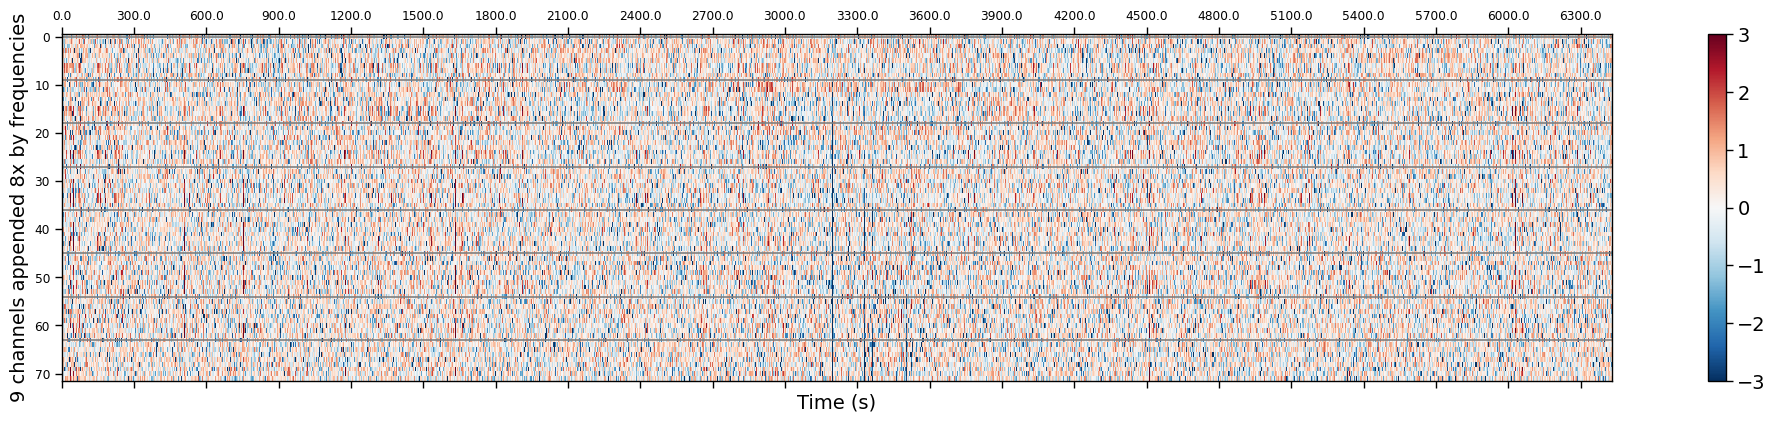

In [49]:
tick_width = 300 # in s

elec_num = np.shape(pow_wavelet)[1]
plt.figure(figsize=(25, 4.5)); ax=plt.subplot(111) 
ax1 = ax.matshow(z_pows.swapaxes(0,1), aspect='auto', cmap='RdBu_r', vmin=-3, vmax=3)
plt.ylabel(str(elec_num)+' channels appended 8x by frequencies')
plt.xlabel('Time (s)',fontsize=14)

# Time calculations
data_points_per_tick = tick_width * desired_samplerate  # seconds * sr
tick_indices = np.arange(0, len(z_pows)+data_points_per_tick, data_points_per_tick)
time_labels = tick_indices / desired_samplerate  # Convert indices to time

# Setting x-ticks and labels
ax.set_xticks(tick_indices)
ax.set_xticklabels(np.round(time_labels, 2))  # Rounding for cleaner display
ax.set_xlim([0, len(z_pows) + 1])

for ln in range(8):    
    plt.plot([0, len(z_pows)],[elec_num*ln, elec_num*ln],color=(0.5,0.5,0.5)) 
cbar = plt.colorbar(ax1)
cbar.ax.tick_params(labelsize=14)
# plt.ylabel('Trial',fontsize=14)
# ax.set_xticklabels([])
# ax.set_yticklabels([])
# ax.set_yticks([])  
# plt.savefig('example_zscore_heatmap.png')
a=1;

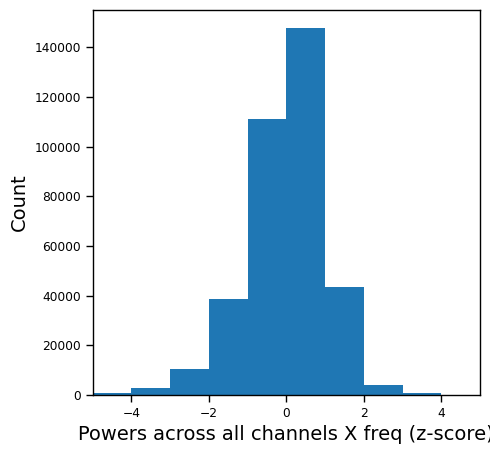

In [50]:
# plot distribution of z-scores
np.shape(z_pows)
test = z_pows[0:5000,:]
np.shape(test)
np.shape(test.flatten())
fig,ax = plt.subplots(1,1,figsize=(5,5))
plt.hist(test.flatten(),np.arange(-5,5))
ax.set_xlim(-5,5)
plt.ylabel('Count')
plt.xlabel('Powers across all channels X freq (z-score)');

## Slice up data into "trials" so can check for corrupt channels over time

In [51]:
save_plots = 0

import seaborn as sb
sb.set_context("paper", rc={"font.size":10,"axes.titlesize":12,"axes.labelsize":12,
                            "axes.ticksize":12,"axes.titlesize":12})
from ptsa.data.filters import ResampleFilter

# now you have:
# A) lfp_mat, which is 60-Butterworth-filtered channel X time raw EEG at desired_samplerate (prob 1000 Hz)
# B) create line_filt_data, which is lfp_mat converted to trials X channels X bins
sr = lfp_mat.samplerate.values
sr_factor = 1000//sr

# convert data into "trials" by arbitrarily separating EEG using the following parameters
trial_window = 1500//sr_factor
ITI = 1000//sr_factor
jitter_max = 2000//sr_factor # minimum is 0 
max_data_chunk = trial_window+ITI+jitter_max
# max number of trials from this arbitrary trial breakdown
num_trials = int(np.shape(lfp_mat)[-1]/max_data_chunk) 

line_filt_data = []
z_pow_all = []
for tr in range(num_trials):
    jitter = int(np.random.uniform(0,jitter_max))
    start_idx = int(max_data_chunk*tr+jitter)
    end_idx = start_idx+trial_window+ITI
    line_filt_data.append(lfp_mat[:,start_idx:end_idx])
    # for the z_pows can create your trials and avg the signal all in one line (no decimation needed)
    z_pow_all.append(np.mean(pow_wavelet[:,:,start_idx:end_idx],2))
# print('done resample feature'+str(freq+1))
line_filt_data = np.array(line_filt_data)
print('Shape line_filt_data (which is lfp_mat broken into trials):')
np.shape(line_filt_data)
z_pow_all = np.swapaxes(z_pow_all,1,2) # move to trial X ch X freq
print('Shape z_pow_all:')
np.shape(z_pow_all)


Shape line_filt_data (which is lfp_mat broken into trials):


(1428, 9, 1250)

Shape z_pow_all:


(1428, 9, 8)

## get std of raw timeseries and correlations of spectral features for plots below

In [52]:
sr = lfp_mat.samplerate.values
time_range = range(0,trial_window) # 0:2000 ms 
plot_range = range(5,382) # freq. range of PSDs. first few are strange...then only go to 200 Hz (which is 400 after Fourier halving)

from adjustText import adjust_text

ch_z_pow = []
ch_std = []
ch_z_pow_mat = []
ch_std_mat = []
for ch in range(np.shape(line_filt_data)[1]):

    z_pows = []
    temp_std = []

    for tr in range(np.shape(line_filt_data)[0]):

        y = line_filt_data[tr,ch,time_range]
        temp_std.append(np.std(y))
        if tr < np.shape(line_filt_data)[0]-1: # last one don't look for correlation
            z_pows.append(np.corrcoef(z_pow_all[tr,ch,:],z_pow_all[tr+1,ch,:])[0,1])

    ch_z_pow.append(np.mean(z_pows))
    ch_std.append(np.mean(temp_std))
    ch_z_pow_mat.append(z_pows) # append to get the full matrix
    ch_std_mat.append(temp_std)

    if ch == int(np.median(range(np.shape(line_filt_data)[1]))):
        print('Halfway there buddy!')
print('Done getting ur measurements')

Halfway there buddy!
Done getting ur measurements


In [53]:
# get the peak_valley of highpassed raw EEG (similar to STD metric)
highpass_value = 2

# remake the PTSA TimeSeries
line_filt_data = TimeSeries(line_filt_data, 
                dims=('trial','channel', 'time'),
                coords={'trial':np.arange(0,np.shape(line_filt_data)[0]),
                        'channel':channels,
                        'time':np.arange(0,np.shape(line_filt_data)[2]),
                        'samplerate':sr})
lfp_highpass = ButterworthFilter(freq_range=[highpass_value], filt_type='highpass', order=4).filter(timeseries=line_filt_data)

ch_highpass_pv = []
ch_highpass_pv_mat = []
for ch in range(np.shape(lfp_highpass)[1]):

    pv = []
    for tr in range(np.shape(lfp_highpass)[0]):

        y = lfp_highpass[tr,ch,time_range]
        pv.append(np.sort(y)[-5] - np.sort(y)[5]) # 5th highest value minus 5th lowest value

    ch_highpass_pv.append(np.mean(pv))
    ch_highpass_pv_mat.append(pv)

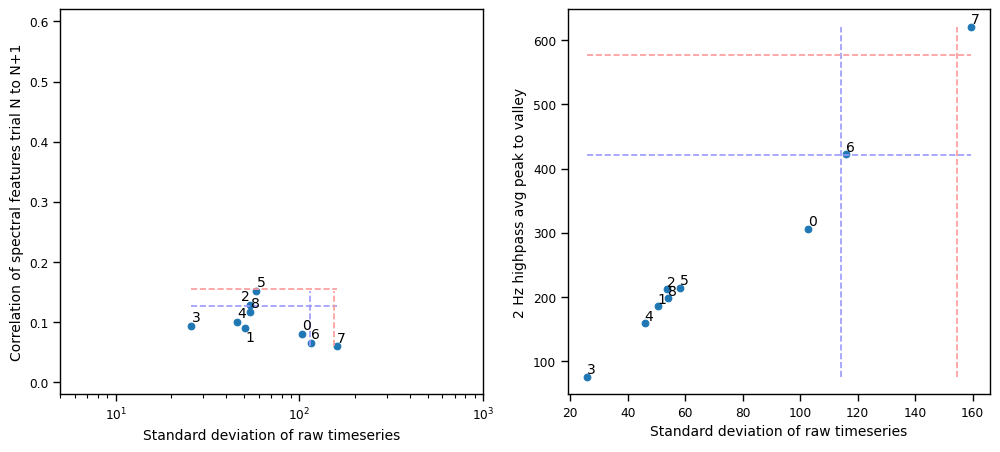

In [54]:
# make scatterplot
save_plots = 0
fix_labels = 1 # This will make the channel labels more readable...but it takes like 20 seconds so can be annoying

# values out of range to min and max values for visualization
max_corr = 0.6
min_corr = 0
max_std = 1e3
min_std = 5

temp_ch_z_pow = np.array(ch_z_pow); 
temp_ch_z_pow[temp_ch_z_pow>max_corr] = max_corr
temp_ch_z_pow[temp_ch_z_pow<min_corr] = min_corr

temp_ch_std = np.array(ch_std)
temp_ch_std[temp_ch_std>max_std] = max_std
temp_ch_std[temp_ch_std<min_std] = min_std


# plot correlations of spectral powers at arbitrary time points vs. std of raw values
plt.subplots(1,2,figsize=(12,5))
ax = plt.subplot(1,2,1)
ax,texts = scatterWithFirstSecondStds(ax,temp_ch_std, temp_ch_z_pow)
plt.xlabel('Standard deviation of raw timeseries')
plt.ylabel('Correlation of spectral features trial N to N+1')
ax.set_xscale('log')
ax.set_xlim(min_std,max_std)
ax.set_ylim(min_corr-0.02,max_corr+0.02)
if fix_labels == 1:
    adjust_text(texts)
# ax.set_title(df_sess['subject']+', session '+str(df_sess['session'])+', '+df_sess['experiment'])

# plot corr of spectral powers v. min/max of highpassed LFP
ax = plt.subplot(1,2,2)
ax,texts = scatterWithFirstSecondStds(ax,temp_ch_std, ch_highpass_pv)
plt.ylabel(str(highpass_value)+' Hz highpass avg peak to valley')
plt.xlabel('Standard deviation of raw timeseries')
# ax.set_xscale('log')
# ax.set_xlim(min_std,max_std)
# ax.set_ylim(min_corr-0.02,max_corr+0.02)

if save_plots == 1:
    plot_directory = '../figures/corruption_detection_plots/corruption_detection_'+exp +'_'+ df_sess['subject'] +'_'+ str(df_sess['session'])+'.pdf'
    plt.savefig(plot_directory,transparent=True)
a=1;

## print bipolar channel names

In [55]:
[print(str(i_name)+': '+channel_name) for i_name,channel_name in enumerate(channel_names)]
a=1;

0: ata/LAH1.ncs - ata/LAH2.ncs
1: ata/LAH2.ncs - ata/LAH3.ncs
2: ata/LAH3.ncs - ata/LAH4.ncs
3: data/RA1.ncs - data/RA2.ncs
4: data/RA2.ncs - data/RA3.ncs
5: data/RA3.ncs - data/RA4.ncs
6: ata/RAH1.ncs - ata/RAH2.ncs
7: ata/RAH2.ncs - ata/RAH3.ncs
8: ata/RAH3.ncs - ata/RAH4.ncs


# To plot individual trials from individual channels to get an idea of why channels are corrupted

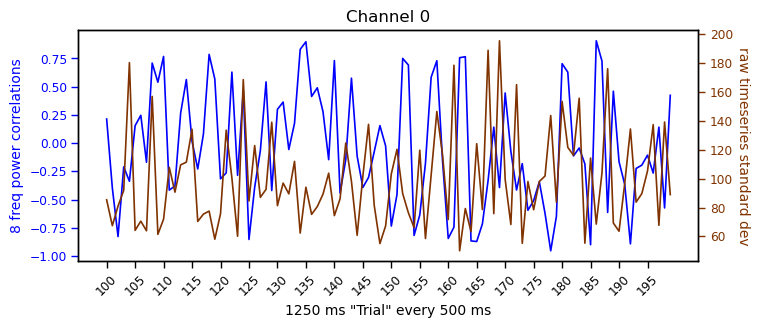

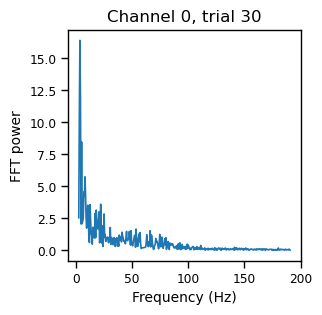

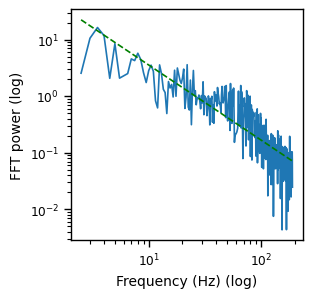

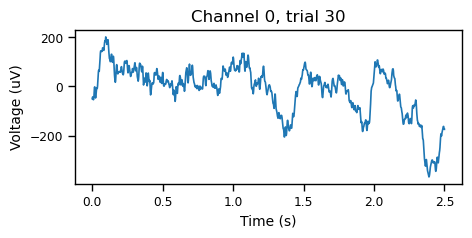

In [56]:
channel = 0
trial = 30

# for channel plot z_pows and std over trials to see where issues occur
channel_plot_range = np.arange(0,len(line_filt_data)-1) # all trials
channel_plot_range = np.arange(100,200)

from scipy.fft import fft
from scipy.stats import linregress,siegelslopes,theilslopes
N = 1000 #np.shape(line_filt_dat)[2] # Number of samplepoints 
T = 1.0 / N # sample spacing  
time_range = range(0,int(2000*(sr/1000))) # 2000 ms 
plot_range = range(5,382) # freq. range of PSDs. first few are strange...then only go to 200 Hz (which is 400)
shift_factor = 1 # taking different time chunks shifts the frequencies


y = line_filt_data[int(trial),channel,time_range].to_numpy()

fig,ax = plt.subplots(1,1,figsize=(8,3))
color1 = (0,0,1); color2 = (0.5,0.2,0)
ax.plot(np.array(ch_z_pow_mat)[channel,channel_plot_range],color=color1)
ax.yaxis.label.set_color(color1); ax.tick_params(axis='y', colors=color1)
ax.set_xlabel(str(int(trial_window+ITI))+' ms "Trial" every '+\
              str(int(jitter_max/2))+ ' ms')
if len(channel_plot_range)<=100:
    # actual locations then labels
    ax.set_xticks(np.arange(0,len(channel_plot_range),5),\
        np.arange(channel_plot_range[0],channel_plot_range[0]+len(channel_plot_range),5),rotation=45)


ax.set_ylabel(r'8 freq power correlations')
ax2 = ax.twinx()
ax2.plot(np.array(ch_std_mat)[channel,channel_plot_range],color=color2); ax2.tick_params(axis='y', colors=color2)
ax2.yaxis.label.set_color(color2)
ax2.set_ylabel(r'raw timeseries standard dev',rotation=270,va="bottom", labelpad=2)
plt.title('Channel '+str(channel))
plt.show()
    
# FFT plot
plt.subplots(1,1,figsize=(3,3))
yf = fft(y)
# get the frequency spectrum after the fft by removing mirrored signal and taking modulus
corrected_yf = shift_factor/N * np.abs(yf[:N//2]) 
xf = np.linspace(0.0, N/2, N) 
plt.plot(xf[plot_range],corrected_yf[plot_range])
plt.ylabel('FFT power'); plt.xlabel('Frequency (Hz)')
plt.title('Channel '+str(channel)+', trial '+str(trial))
plt.show()

# log-log FFT with fit of slope
plt.subplots(1,1,figsize=(3,3))
xplot = xf[plot_range]
yplot = corrected_yf[plot_range]
spectrum_slope = np.polyfit(np.log(xplot), np.log(yplot), 1)
# spectrum_slope = siegelslopes(np.log(xplot), np.log(yplot)) # robust regression
spectrum_val = spectrum_slope[0]*np.log(xplot)+spectrum_slope[1] #np.polyval(spectrum_slope,np.log(xplot))
plt.loglog(xplot,yplot)
plt.loglog(xplot,[np.exp(n) for n in spectrum_val], 'g--')
plt.ylabel('FFT power (log)'); plt.xlabel('Frequency (Hz) (log)')
# fit with linear regression and get r^2
slope, intercept, r_value, _, _ = linregress(np.log(xplot), np.log(yplot))
r2 = r_value**2 # same as np.corrcoef^2 for linear regression
# plt.text(100,0,'r^2 = '+str(np.round(r2,2)))
abs_dist = np.mean(np.abs([np.exp(n) for n in spectrum_val]-np.log(yplot)))
plt.show()

# plot raw data
sr = line_filt_data.samplerate.values # should be the same as above but just in case
plt.subplots(1,1,figsize=(5,2))
# Calculate the time for each sample
time = np.linspace(0, len(line_filt_data[trial, channel, :]) / sr, len(line_filt_data[trial, channel, :]))
plt.plot(time,line_filt_data[trial,channel,:])
# plt.title(df_sess['subject']+'-'+str(df_sess['session'])+ ' raw data for channel '+str(channel)+', trial '+str(trial)+', SR = '+str(sr))
plt.ylabel('Voltage (uV)')
plt.xlabel('Time (s)')
plt.title('Channel '+str(channel)+', trial '+str(trial))
plt.show()

a=1;

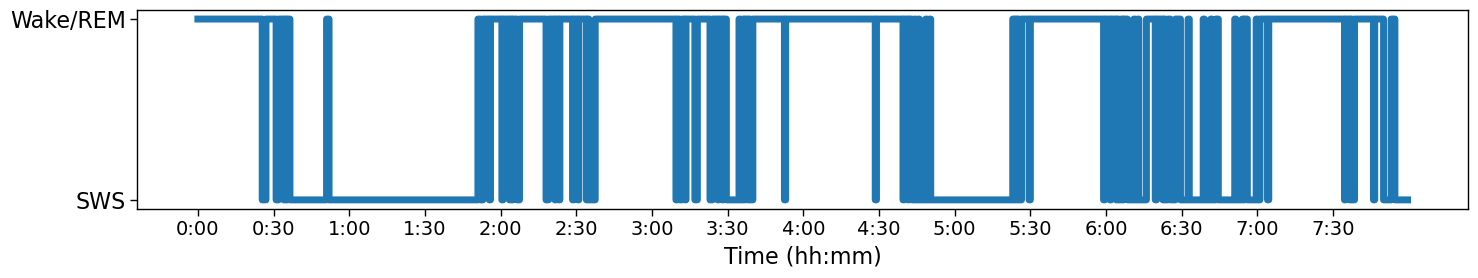

In [57]:
sleep_df = pd.read_csv('/u/project/ifried/jsakon/564/564_Movie_pre- and post-sleep LFP/ZUGARO_EXP4_MTLONLY_SLEEP/EXP4_Movie24&564.csv')
# sleep_df = pd.read_csv('/u/project/ifried/jsakon/566/EXP8_Movie_25_Sleep/EXP8_Movie24&566_firstpass.csv')

sleep_df['NumericScore'] = sleep_df['Score'].astype('category').cat.codes

# Calculate the number of data points in 30 minutes assuming each point represents 30 seconds
points_in_30_min = (30 * 60) // 30

# Find out how many 30-minute increments fit into the dataset length
num_30_min_increments = len(sleep_df) // points_in_30_min

# If the dataset doesn't end exactly on a 30-minute increment, add one more to include the last partial increment
if len(sleep_df) % points_in_30_min != 0:
    num_30_min_increments += 1

# Generate tick positions and labels
tick_positions = [i * points_in_30_min for i in range(num_30_min_increments)]
tick_labels = [f"{int(i/2)}:{'00' if i % 2 == 0 else '30'}" for i in range(num_30_min_increments)]

# Plot the data
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(15, 3))
plt.plot(sleep_df['NumericScore'], drawstyle='steps-pre',linewidth=5)  # drawstyle='steps-pre' shows when changes occur

# Set the tick positions and labels on the x-axis
plt.xticks(ticks=tick_positions, labels=tick_labels, fontsize=14)
if len(sleep_df['Score'].astype('category').cat.categories) == 2:
    plt.yticks(ticks=[0, 1], labels=sleep_df['Score'].astype('category').cat.categories, fontsize=16)
elif len(sleep_df['Score'].astype('category').cat.categories) == 3:
    plt.yticks(ticks=[0, 1, 2], labels=sleep_df['Score'].astype('category').cat.categories, fontsize=16)
plt.xlabel('Time (hh:mm)', fontsize=16)
# plt.ylabel('State', fontsize=14)
# plt.title('State Changes Over Time', fontsize=14)
plt.tight_layout()  # Adjust the padding between and around subplots.
plt.show()

a=1;